In [22]:
import geopandas as gpd
from shapely.ops import unary_union

def aggregate_blocks(shapefile_path, pop_threshold, margin_error):
    # Load the shapefile
    gdf = gpd.read_file(shapefile_path)
    
    # Calculate population sum for each block
    gdf['Population'] = gdf['VALUE9']  # Assuming 'VALUE9' column contains population data
    
    # Define an empty list to store grouped polygons and their population
    grouped_polygons = []
    grouped_populations = []
    
    # Iterate over blocks to find adjacent ones and merge them
    for index, row in gdf.iterrows():
        if row['Population'] >= (pop_threshold - margin_error):
            # If the block already meets the threshold, add it directly to the grouped polygons
            grouped_polygons.append(row.geometry)
            grouped_populations.append(row['Population'])
        else:
            # Find adjacent blocks
            adjacent_blocks = [row]
            for _, neighbor_row in gdf.iterrows():
                if row.geometry.touches(neighbor_row.geometry):
                    adjacent_blocks.append(neighbor_row)
                    
            # Merge adjacent blocks
            merged_block = unary_union([poly.geometry for poly in adjacent_blocks])
            
            # Calculate the total population of adjacent blocks
            total_population = sum(adj_block.Population for adj_block in adjacent_blocks)
            
            # Check if the total population meets the threshold with the margin of error
            if total_population >= (pop_threshold - margin_error):
                # If population meets the threshold, add it to the list of grouped polygons
                grouped_polygons.append(merged_block)
                grouped_populations.append(total_population)
    
    # Create a GeoDataFrame from the grouped polygons and populations
    grouped_gdf = gpd.GeoDataFrame(geometry=grouped_polygons, data={'Population': grouped_populations})
    
    return grouped_gdf

# Example usage
shapefile_path = 'datasets/shapefiles/SimplyAnalytics_Shapefiles_2024-03-25_15_51_20_06bb5972b23ee930944d21c6a8f8c132.shp'
pop_threshold = 5000
margin_error = 1000

grouped_blocks = aggregate_blocks(shapefile_path, pop_threshold, margin_error)
grouped_blocks


,Population,geometry
0,8804.0,"POLYGON ((-82.94694 42.44282, -82.94732 42.442..."
1,5597.0,"POLYGON ((-82.94694 42.44282, -82.94732 42.442..."
2,5892.0,"POLYGON ((-82.98295 42.44227, -82.98049 42.442..."
3,7418.0,"POLYGON ((-82.94694 42.44282, -82.94732 42.442..."
4,7578.0,"POLYGON ((-82.96149 42.43470, -82.96101 42.433..."
...,...,...
572,9885.0,"POLYGON ((-83.06359 42.36598, -83.06326 42.366..."
573,9504.0,"POLYGON ((-82.98492 42.36737, -82.98405 42.367..."
574,4277.0,"POLYGON ((-83.01693 42.33526, -83.01705 42.335..."
575,17059.0,"POLYGON ((-83.25608 42.34180, -83.25729 42.341..."


In [34]:
import geopandas as gpd
from shapely.ops import unary_union

def aggregate_blocks(shapefile_path, pop_threshold, margin_error):
    # Load the shapefile
    gdf = gpd.read_file(shapefile_path)
    
    # Calculate population sum for each block
    gdf['Population'] = gdf['VALUE9']  # Assuming 'VALUE9' column contains population data
    
    # Define an empty list to store grouped polygons and their total population
    grouped_polygons = []
    grouped_population = []
    
    # Define a set to store indices of blocks that have been merged
    merged_indices = set()
    
    # Iterate over blocks to find adjacent ones and merge them
    for index, row in gdf.iterrows():
        if index not in merged_indices:
            if row['Population'] >= (pop_threshold - margin_error):
                # If the block already meets the threshold, add it directly to the grouped polygons
                grouped_polygons.append(row.geometry)
                grouped_population.append(row['Population'])
            else:
                # Find adjacent blocks
                adjacent_blocks = [row]
                for _, neighbor_row in gdf.iterrows():
                    if index != neighbor_row.name and neighbor_row.name not in merged_indices:
                        if row.geometry.touches(neighbor_row.geometry):
                            adjacent_blocks.append(neighbor_row)
                            merged_indices.add(neighbor_row.name)
                            
                # Merge adjacent blocks
                merged_block = unary_union([poly.geometry for poly in adjacent_blocks])
                
                # Calculate the total population of adjacent blocks
                total_population = sum(adj_block.Population for adj_block in adjacent_blocks)
                
                # Check if the total population meets the threshold with the margin of error
                if total_population >= (pop_threshold - margin_error):
                    # If population meets the threshold, add it to the list of grouped polygons
                    grouped_polygons.append(merged_block)
                    grouped_population.append(total_population)
                    merged_indices.add(row.name)
    
    # Create a GeoDataFrame for the grouped polygons and their total population
    grouped_gdf = gpd.GeoDataFrame(geometry=grouped_polygons)
    grouped_gdf['Population'] = grouped_population
    
    return grouped_gdf

# Example usage
shapefile_path = 'datasets/shapefiles/SimplyAnalytics_Shapefiles_2024-03-25_15_51_20_06bb5972b23ee930944d21c6a8f8c132.shp'
pop_threshold = 5000
margin_error = 1000

grouped_blocks = aggregate_blocks(shapefile_path, pop_threshold, margin_error)


In [35]:
grouped_blocks

,geometry,Population
0,"POLYGON ((-82.94694 42.44282, -82.94732 42.442...",8804.0
1,"POLYGON ((-82.99461 42.40932, -82.99398 42.410...",6999.0
2,"POLYGON ((-82.95863 42.41723, -82.95919 42.416...",8872.0
3,"POLYGON ((-82.94861 42.42045, -82.94733 42.422...",5533.0
4,"POLYGON ((-82.94976 42.38697, -82.95076 42.386...",6636.0
...,...,...
65,"POLYGON ((-83.26292 42.36435, -83.26272 42.364...",5764.0
66,"POLYGON ((-83.21587 42.34337, -83.21572 42.343...",9633.0
67,"POLYGON ((-83.22540 42.33569, -83.22540 42.335...",4373.0
68,"POLYGON ((-83.22579 42.34694, -83.22565 42.343...",9071.0


In [36]:
import folium
import geopandas as gpd

# Function to convert GeoDataFrame to GeoJSON format
def df_to_geojson(df, properties):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in df.iterrows():
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Polygon',
                               'coordinates':[]}}
        feature['geometry']['coordinates'] = [list(row.geometry.exterior.coords)]
        for prop in properties:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson

# Convert GeoDataFrame to GeoJSON
geojson_data = df_to_geojson(grouped_blocks, properties=['Population'])

# Create Folium map centered on the average coordinates of the superblocks
map_center = [grouped_blocks.geometry.centroid.y.mean(), grouped_blocks.geometry.centroid.x.mean()]
mymap = folium.Map(location=map_center, zoom_start=10)

# Add GeoJSON data representing the superblocks to the map
folium.GeoJson(geojson_data, tooltip=folium.GeoJsonTooltip(fields=['Population'], aliases=['Population'])).add_to(mymap)

# Display the map
mymap


<Axes: >

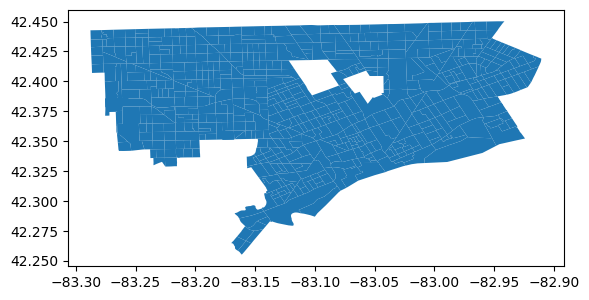

In [45]:
merged_blocks.plot()

In [44]:
import geopandas as gpd
import numpy as np

def merge_blocks_by_population_threshold(shapefile_path, population_threshold, margin_of_error):
    """
    Merges adjacent blocks in a shapefile based on a population threshold.

    Args:
        shapefile_path (str): Path to the shapefile.
        population_threshold (int): Desired population threshold.
        margin_of_error (int): Margin of error for population (e.g., 3000).

    Returns:
        gpd.GeoDataFrame: A new GeoDataFrame with merged blocks.
    """
    # Read the shapefile
    gdf = gpd.read_file(shapefile_path)

    # Calculate the total population for each block
    gdf['Total_Population'] = gdf['VALUE9'] + np.random.randint(-margin_of_error, margin_of_error, len(gdf))

    # Initialize a list to store merged geometries
    merged_geometries = []

    # Initialize a set to keep track of processed block IDs
    processed_ids = set()

    # Iterate through each block
    for idx, row in gdf.iterrows():
        if idx not in processed_ids:
            # Initialize a list to store adjacent block IDs
            adjacent_ids = [idx]

            # Initialize a queue for breadth-first search
            queue = [idx]

            # Perform breadth-first search to find adjacent blocks
            while queue:
                current_id = queue.pop(0)
                processed_ids.add(current_id)

                # Get the neighbors (adjacent blocks) of the current block
                neighbors = gdf[gdf.geometry.touches(gdf.loc[current_id, 'geometry'])]

                # Filter neighbors based on population threshold
                neighbors = neighbors[neighbors['Total_Population'] >= population_threshold]

                # Add neighbor IDs to the queue
                queue.extend(neighbors.index.tolist())

                # Add neighbor IDs to the adjacent_ids list
                adjacent_ids.extend(neighbors.index.tolist())

            # Merge the geometries of adjacent blocks
            merged_geometry = gdf.loc[adjacent_ids, 'geometry'].unary_union
            merged_geometries.append(merged_geometry)

    # Create a new GeoDataFrame with merged geometries
    merged_gdf = gpd.GeoDataFrame(geometry=merged_geometries)

    return merged_gdf

# Example usage:
shapefile_path = 'datasets/shapefiles/SimplyAnalytics_Shapefiles_2024-03-25_15_51_20_06bb5972b23ee930944d21c6a8f8c132.shp'
population_threshold = 5000
margin_of_error = 3000
merged_blocks = merge_blocks_by_population_threshold(shapefile_path, population_threshold, margin_of_error)

# Save the merged blocks to a new shapefile
merged_blocks.to_file("merged_blocks.shp")

# Print a success message
print("Merged blocks saved to merged_blocks.shp")


Merged blocks saved to merged_blocks.shp
